<a href="https://colab.research.google.com/github/Panatore/RoomsClassifier/blob/main/TFM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
hello = tf.constant('Hello, Tensorflow!')
print(hello)

tf.Tensor(b'Hello, Tensorflow!', shape=(), dtype=string)


In [2]:
if tf.config.list_physical_devices('GPU'):
  print("TensorFlow **IS** using the GPU")
else:
  print("TensorFlow **IS NOT** using the GPU")

TensorFlow **IS NOT** using the GPU


# Load the data of the directory

In [32]:
data_dir = "./data"

In [33]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 934 files belonging to 5 classes.
Using 748 files for training.


In [34]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(256,256),
  batch_size=32)

Found 934 files belonging to 5 classes.
Using 186 files for validation.


In [35]:
class_names = train_ds.class_names
print(class_names)

['Bathroom', 'Bedroom', 'House Map', 'Kitchen', 'Living Room']


Show a sample of the 9 first images

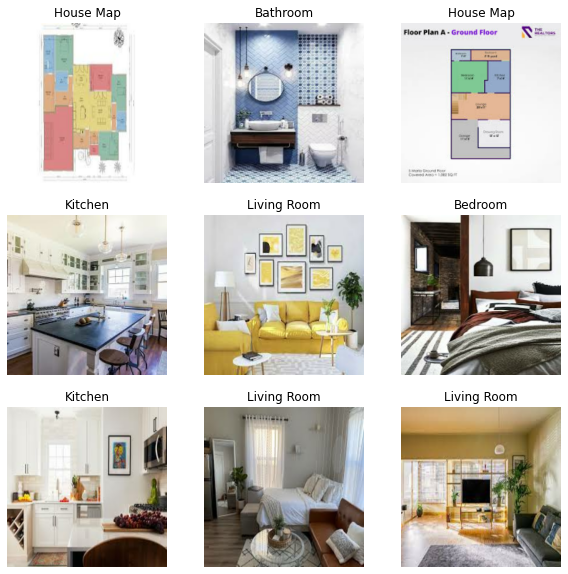

In [36]:
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [37]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 256, 256, 3)
(32,)


# Preprocess data

Scale the image dividing it by 255

In [38]:
from keras.layers import Rescaling

In [39]:
normalization_layer = Rescaling(1./255)

In [40]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x),y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

0.0 1.0


# Split the data

In [41]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Activation, Dropout, Flatten, Dense

In [46]:
numberOfClass = len(class_names)

model = Sequential()
model.add(Conv2D(32,(3,3),input_shape = (256,256,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3)))
model.add(Activation("relu"))
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(Dropout(0.5))
model.add(Dense(numberOfClass)) # output
model.add(Activation("softmax"))

In [47]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [48]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 254, 254, 32)      896       
                                                                 
 activation_15 (Activation)  (None, 254, 254, 32)      0         
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 conv2d_10 (Conv2D)          (None, 125, 125, 32)      9248      
                                                                 
 activation_16 (Activation)  (None, 125, 125, 32)      0         
                                                                 
 max_pooling2d_10 (MaxPoolin  (None, 62, 62, 32)       0         
 g2D)                                                 

In [49]:
epochs=50
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/50


c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\tensorflow\python\util\dispatch.py:1082: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  return dispatch_target(*args, **kwargs)


24/24 [==============================] - 42s 2s/step - loss: 435.6529 - accuracy: 0.2032 - val_loss: 1.6797 - val_accuracy: 0.2043
Epoch 2/50
24/24 [==============================] - 42s 2s/step - loss: 1.4823 - accuracy: 0.3904 - val_loss: 1.6653 - val_accuracy: 0.2204
Epoch 3/50
24/24 [==============================] - 44s 2s/step - loss: 1.1231 - accuracy: 0.5615 - val_loss: 1.7903 - val_accuracy: 0.2634
Epoch 4/50
24/24 [==============================] - 38s 2s/step - loss: 0.7748 - accuracy: 0.7166 - val_loss: 2.3130 - val_accuracy: 0.3065
Epoch 5/50
24/24 [==============================] - 36s 2s/step - loss: 0.4531 - accuracy: 0.8316 - val_loss: 3.3794 - val_accuracy: 0.3172
Epoch 6/50
24/24 [==============================] - 41s 2s/step - loss: 0.3097 - accuracy: 0.8877 - val_loss: 3.4122 - val_accuracy: 0.3602
Epoch 7/50
24/24 [==============================] - 42s 2s/step - loss: 0.3250 - accuracy: 0.9492 - val_loss: 3.4399 - val_accuracy: 0.3602
Epoch 8/50
24/24 [===========

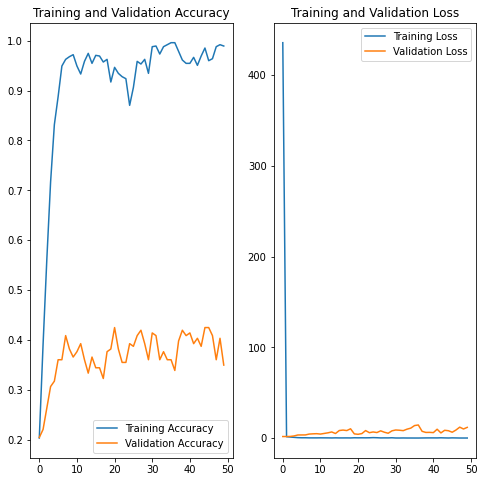

In [50]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [5]:
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.imagenet_utils import preprocess_input

In [6]:
width_shape = 224
height_shape = 224
num_classes = 5
epochs = 50
batch_size = 32 

In [25]:

train_datagen = ImageDataGenerator( 
    rescale= 1./255,
    rotation_range=40,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range= 0.2,
    horizontal_flip=True,
    validation_split= 0.2)

valid_datagen = ImageDataGenerator(rescale= 1./255, validation_split= 0.2)

train_generator = train_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "training",
    batch_size= batch_size)

valid_generator = valid_datagen.flow_from_directory(data_dir,
    target_size=(width_shape, height_shape),
    color_mode="rgb",
    class_mode='categorical',
    subset= "validation",
    batch_size= batch_size)


Found 748 images belonging to 5 classes.
Found 186 images belonging to 5 classes.


In [8]:
import scipy

In [9]:
print(train_generator.next()[0][1])

[[[0.16078432 0.264627   0.3350574 ]
  [0.16078432 0.26343125 0.33147016]
  [0.16129394 0.26121625 0.3299214 ]
  ...
  [0.91372555 0.91372555 0.91372555]
  [0.91388124 0.91388124 0.91388124]
  [0.9176471  0.9176471  0.9176471 ]]

 [[0.16078432 0.26666668 0.34117648]
  [0.16078432 0.26648727 0.34063825]
  [0.16078432 0.2652915  0.337051  ]
  ...
  [0.91372555 0.91372555 0.91372555]
  [0.9147899  0.9147899  0.9147899 ]
  [0.9176471  0.9176471  0.9176471 ]]

 [[0.16093512 0.26681748 0.34162888]
  [0.16078432 0.26666668 0.34117648]
  [0.16078432 0.26666668 0.34117648]
  ...
  [0.91372555 0.91372555 0.91372555]
  [0.91569847 0.91569847 0.91569847]
  [0.9176471  0.9176471  0.9176471 ]]

 ...

 [[0.4839085  0.4839085  0.4839085 ]
  [0.49221578 0.49221578 0.49221578]
  [0.48521242 0.48521242 0.48521242]
  ...
  [0.7894731  0.78555155 0.7777084 ]
  [0.7882773  0.78435576 0.7765126 ]
  [0.78823537 0.7843138  0.77647066]]

 [[0.4829999  0.4829999  0.4829999 ]
  [0.4958503  0.4958503  0.4958503 ]


c:\Users\danie\OneDrive\Documentos\GitHub\RoomsClassifier\env\lib\site-packages\matplotlib\text.py:1223: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


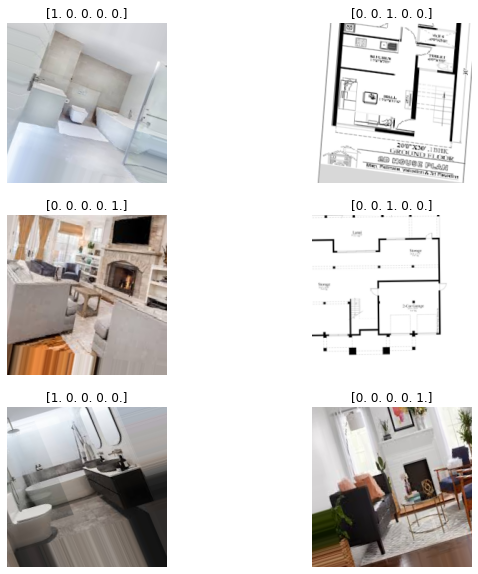

In [10]:
batch =  train_generator.next()
  
plt.figure(figsize=(10, 10))

for i in range(6):
  ax = plt.subplot(3, 2, i + 1)
  plt.imshow(batch[0][i])
  plt.title(batch[1][i])
  plt.axis("off")

In [13]:
from keras.losses import categorical_crossentropy

In [28]:
model.compile(optimizer = 'adam', loss = categorical_crossentropy, metrics = ['accuracy'] )

hist = model.fit_generator(train_generator,
                           epochs = epochs,
                           validation_data= valid_generator
                           )

C:\Users\danie\AppData\Local\Temp\ipykernel_13012\1372790689.py:3: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train_generator,


Epoch 1/50
24/24 [==============================] - 33s 1s/step - loss: 1.9814 - accuracy: 0.2112 - val_loss: 1.5734 - val_accuracy: 0.2849
Epoch 2/50
24/24 [==============================] - 30s 1s/step - loss: 1.5551 - accuracy: 0.2754 - val_loss: 1.5076 - val_accuracy: 0.2419
Epoch 3/50
24/24 [==============================] - 34s 1s/step - loss: 1.5266 - accuracy: 0.3195 - val_loss: 1.4936 - val_accuracy: 0.3387
Epoch 4/50
24/24 [==============================] - 32s 1s/step - loss: 1.4832 - accuracy: 0.3048 - val_loss: 1.4132 - val_accuracy: 0.4516
Epoch 5/50
24/24 [==============================] - 34s 1s/step - loss: 1.4495 - accuracy: 0.3837 - val_loss: 1.2802 - val_accuracy: 0.5054
Epoch 6/50
24/24 [==============================] - 33s 1s/step - loss: 1.4228 - accuracy: 0.3957 - val_loss: 1.2589 - val_accuracy: 0.4785
Epoch 7/50
24/24 [==============================] - 32s 1s/step - loss: 1.3673 - accuracy: 0.4265 - val_loss: 1.2628 - val_accuracy: 0.4355
Epoch 8/50
24/24 [==

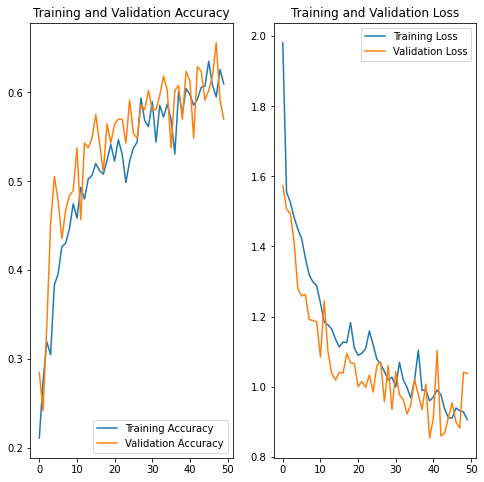

In [29]:
acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']

loss = hist.history['loss']
val_loss = hist.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [52]:
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input
from keras.models import Model

In [53]:
image_input = Input(shape= (224,224,3))

base_model = MobileNetV2(input_tensor= image_input, include_top= False, weights= 'imagenet')

out = Dense(num_classes, activation='softmax')

model = Model(base_model,out)

model.summary()

ValueError: Found unexpected instance while processing input tensors for keras functional model. Expecting KerasTensor which is from tf.keras.Input() or output from keras layer call(). Got: <keras.engine.functional.Functional object at 0x000002978E5925E0>